<a href="https://colab.research.google.com/github/AIEngineerOnDemand/Data-Science-Portfolio/blob/master/vae.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Auto-Encoding Variational Bayes
This notebook intends to reproduce the work of Auto-Encoding Variational Bayes, which bridges the variational inference and auto-encoder theory, and proposes a general efficient learning algorithm on directed probabilistic modelling with latent varaiables.

Our work includes:

- implements the variational auto encoder model for MNIST dataset, consists of:
  - the gaussian MLP encoder, modelling the posterior prob
  - the bernoulli MLP decoder, modelling the generative process
- conduct experiment to study the role of the dimensionality of latent space
- show the learned manifold for the generative model on MNIST

-----------------------
You may refer the blog article for further details: http://jzhou.space/2022/05/06/vae/.

The original notebook on github is here: https://github.com/jz95/ml-paper-lab/blob/master/notebooks/vae.ipynb .

# Prepare Experiment Env
- download repo: https://github.com/jz95/ml-paper-lab
- install dependencies
- install package - paperlab

In [ ]:
!git clone https://github.com/jz95/ml-paper-lab.git
%cd ml-paper-lab/
!pip install -r requirements.txt
!python setup.py develop

Cloning into 'ml-paper-lab'...
remote: Enumerating objects: 196, done.
remote: Counting objects: 100% (196/196), done.
remote: Compressing objects: 100% (125/125), done.
remote: Total 196 (delta 78), reused 176 (delta 58), pack-reused 0
Receiving objects: 100% (196/196), 1.35 MiB | 8.02 MiB/s, done.
Resolving deltas: 100% (78/78), done.
/content/ml-paper-lab
ERROR: Could not find a version that satisfies the requirement torch==1.8.2 (from versions: 1.0.0, 1.0.1, 1.0.1.post2, 1.1.0, 1.2.0, 1.3.0, 1.3.1, 1.4.0, 1.5.0, 1.5.1, 1.6.0, 1.7.0, 1.7.1, 1.8.0, 1.8.1, 1.9.0, 1.9.1, 1.10.0, 1.10.1, 1.10.2, 1.11.0)
ERROR: No matching distribution found for torch==1.8.2
running develop
running egg_info
creating paperlab.egg-info
writing paperlab.egg-info/PKG-INFO
writing dependency_links to paperlab.egg-info/dependency_links.txt
writing top-level names to paperlab.egg-info/top_level.txt
writing manifest file 'paperlab.egg-info/SOURCES.txt'
writing manifest file 'paperlab.egg-info/SOURCES.txt'
runnin

In [ ]:
from paperlab.zoo import vae
from paperlab.core import Config, ExpRunner

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import torch

import os
os.environ['KMP_DUPLICATE_LIB_OK'] = 'True'

In [ ]:
!nvidia-smi

Mon May 23 08:44:04 2022       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 460.32.03    Driver Version: 460.32.03    CUDA Version: 11.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla K80           Off  | 00000000:00:04.0 Off |                    0 |
| N/A   54C    P8    30W / 149W |      0MiB / 11441MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

# Exp1. Dimensionality of latent space
We will study how the dimensionality of latent space affects the performance of VAE model, in terms of optimizing the evidence lower bound.

Based on the studies of auto-encoders, higer dimensionality means larger bottlneck of encoder and more free parameters in the model, thus leads to better fitting performace but also higher risk of overfitting. Let's see if it goes as expected.

In [ ]:
# process the experiment results
def process_exp_results(exp_results):
    train_stats, test_stats = [], []
    for result in exp_results:
        train_elbos, test_elbos = result

        train_stats.append(train_elbos)
        test_stats.append(test_elbos)

    return pd.DataFrame(train_stats).mean(), pd.DataFrame(test_stats).mean()

In [ ]:
# adjust NUM_EPOCH to a larger number for a better result
NUM_EPOCH = 5
LATENT_DIMS = [3, 5, 10, 20, 200]

basic_params = {
    'model.dim_latent': 2,
    'model.dim_input': 28 * 28,
    'model.dim_hidden': 500,
    'learning.batch_size': 100,
    'learning.lr': 0.02,
    'learning.num_epoch': NUM_EPOCH,
}
config = Config(**basic_params)

# change latent space listed in the LATENT_DIMS
stats = {}
for dim_latent in LATENT_DIMS:
    config.model.dim_latent = dim_latent
    # setup the experiment runner, you're encouraged to check source code defined in `vae.exp`
    runner = ExpRunner(exp_func=vae.exp, exp_config={'config': config}, repeat_num=3)
    # run experiment using multi-processing speed up
    runner.run()
    train_elbo_cruve, test_elbo_cruve = process_exp_results(runner.exp_results)
    stats[dim_latent] = train_elbo_cruve, test_elbo_cruve

experiment starts ...
repeat running 3 times, random seeds are [0, 1, 2]
config:
	 config = {'model': {'dim_latent': 3, 'dim_input': 784, 'dim_hidden': 500}, 'learning': {'batch_size': 100, 'lr': 0.02, 'num_epoch': 5}}


0it [00:00, ?it/s]

  0%|          | 0/9912422 [00:00<?, ?it/s]

Extracting /content/ml-paper-lab/.cache/data/MNIST/raw/train-images-idx3-ubyte.gz to /content/ml-paper-lab/.cache/data/MNIST/raw



  0%|          | 0/28881 [00:00<?, ?it/s]

Extracting /content/ml-paper-lab/.cache/data/MNIST/raw/train-labels-idx1-ubyte.gz to /content/ml-paper-lab/.cache/data/MNIST/raw



  0%|          | 0/1648877 [00:00<?, ?it/s]

Extracting /content/ml-paper-lab/.cache/data/MNIST/raw/t10k-images-idx3-ubyte.gz to /content/ml-paper-lab/.cache/data/MNIST/raw



  0%|          | 0/4542 [00:00<?, ?it/s]

Extracting /content/ml-paper-lab/.cache/data/MNIST/raw/t10k-labels-idx1-ubyte.gz to /content/ml-paper-lab/.cache/data/MNIST/raw



3it [03:00, 60.18s/it]


experiment starts ...
repeat running 3 times, random seeds are [0, 1, 2]
config:
	 config = {'model': {'dim_latent': 5, 'dim_input': 784, 'dim_hidden': 500}, 'learning': {'batch_size': 100, 'lr': 0.02, 'num_epoch': 5}}


3it [02:46, 55.42s/it]


experiment starts ...
repeat running 3 times, random seeds are [0, 1, 2]
config:
	 config = {'model': {'dim_latent': 10, 'dim_input': 784, 'dim_hidden': 500}, 'learning': {'batch_size': 100, 'lr': 0.02, 'num_epoch': 5}}


3it [02:45, 55.16s/it]


experiment starts ...
repeat running 3 times, random seeds are [0, 1, 2]
config:
	 config = {'model': {'dim_latent': 20, 'dim_input': 784, 'dim_hidden': 500}, 'learning': {'batch_size': 100, 'lr': 0.02, 'num_epoch': 5}}


3it [02:45, 55.28s/it]


experiment starts ...
repeat running 3 times, random seeds are [0, 1, 2]
config:
	 config = {'model': {'dim_latent': 200, 'dim_input': 784, 'dim_hidden': 500}, 'learning': {'batch_size': 100, 'lr': 0.02, 'num_epoch': 5}}


3it [02:47, 55.71s/it]


We repeat experiment 3 times under each setting, and plot the average values of evidence lower bound on training and test dataset. Basically, the result seems to go with our assumption, that more latent variables leads to better optimizing performance. But, as shown in the rightmost panel, the increasing latent space dimensionality doesnt casuse overfiiting, due to the regularizing effect of the KL divergence term in the ELBO.

In [ ]:
fig, ax = plt.subplots(ncols=len(LATENT_DIMS),
                       figsize=(6 * len(LATENT_DIMS), 5),
                       sharey=True,
                       gridspec_kw={'wspace':0.1})

for i, dim_latent in enumerate(stats):
    train_elbo_cruve, test_elbo_cruve = stats[dim_latent]

    ax[i].plot(train_elbo_cruve.index, train_elbo_cruve.values, label='train')
    ax[i].plot(test_elbo_cruve.index, test_elbo_cruve.values, label='test')
    ax[i].set_ylim(-150, -100)
    ax[i].set_xscale('log')
    ax[i].set_title(f"Nz={dim_latent}")

ax[0].set_xlabel('# Training samples evaluated')
ax[0].set_ylabel('elbo')
ax[0].legend()

# Exp2. Learn MNIST Manifold
We restrict the size of latent space to 2, vary generated the value of in both two directions to produce a series of linearly spaced 2d latent variables. Then we plot the images generated by the given 2d latent variables.

In [ ]:
# adjust NUM_EPOCH to a larger number for a better result
NUM_EPOCH = 20

###
basic_params = {
    'model.dim_latent': 2,
    'model.dim_input': 28 * 28,
    'model.dim_hidden': 500,
    'learning.batch_size': 100,
    'learning.lr': 0.02,
    'learning.num_epoch': NUM_EPOCH,
}
config = Config(**basic_params)
model, *_ = vae.exp(config, return_model=True)

  0%|          | 0/9912422 [00:00<?, ?it/s]

Extracting /content/ml-paper-lab/.cache/data/MNIST/raw/train-images-idx3-ubyte.gz to /content/ml-paper-lab/.cache/data/MNIST/raw



  0%|          | 0/28881 [00:00<?, ?it/s]

Extracting /content/ml-paper-lab/.cache/data/MNIST/raw/train-labels-idx1-ubyte.gz to /content/ml-paper-lab/.cache/data/MNIST/raw



  0%|          | 0/1648877 [00:00<?, ?it/s]

Extracting /content/ml-paper-lab/.cache/data/MNIST/raw/t10k-images-idx3-ubyte.gz to /content/ml-paper-lab/.cache/data/MNIST/raw



  0%|          | 0/4542 [00:00<?, ?it/s]

Extracting /content/ml-paper-lab/.cache/data/MNIST/raw/t10k-labels-idx1-ubyte.gz to /content/ml-paper-lab/.cache/data/MNIST/raw



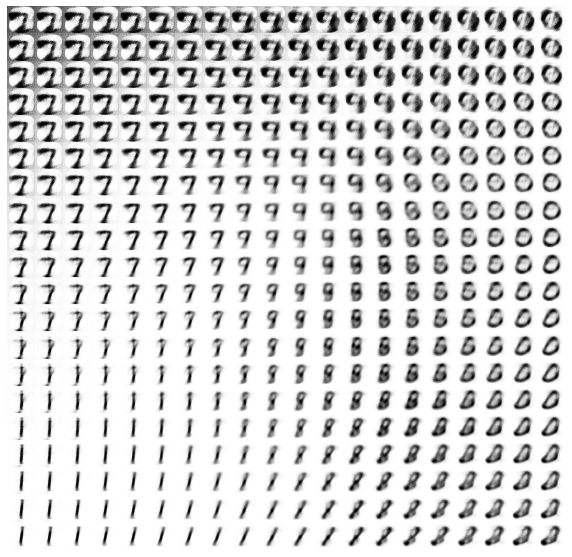

In [ ]:
num_row, num_col = 20, 20

# draw samples from encoder
xs, ys = np.meshgrid(np.linspace(-3, 3, num_row), np.linspace(-3, 3, num_col))
z = np.stack([xs.flatten(), ys.flatten()], axis=1)
z = torch.tensor(z, dtype=torch.float)
if torch.cuda.is_available():
    z = z.cuda()
draw_samples = model.decoder.prob(z)
imgs = draw_samples.cpu().data.numpy().reshape(-1, 28, 28)

# show the samples
f, ax = plt.subplots(num_row, num_col,
                     figsize=(10, 10),
                     gridspec_kw={'wspace':0, 'hspace':0},
                     squeeze=True)

for i in range(num_row):
    for j in range(num_col):
        im = imgs[num_row * i + j]
        ax[i, j].imshow(im, cmap='Greys', aspect='auto')
        ax[i, j].axis('off')